# Adjoint Plugin: 3 Inverse Design Demo

In this notebook, we will use inverse design and the tidy3d adjoint plugin to create an integrated photonics component to convert a fundamental waveguide mode to a higher order mode.

In [1]:
from typing import List
import numpy as np
import matplotlib.pylab as plt

# import jax to be able to use automatic differentiation
import jax.numpy as jnp
from jax import grad, value_and_grad

# import regular tidy3d 
import sys; sys.path.append('../../../tidy3d')
import tidy3d as td
import tidy3d.web as web
from tidy3d.plugins import ModeSolver

# import the components we need from the adjoint plugin
from tidy3d.plugins.adjoint import JaxSimulation, JaxBox, JaxMedium, JaxStructure, JaxSimulationData
from tidy3d.plugins.adjoint.web import run

# turn off the logging warnings, because we will trigger many unnecessarily
td.config.logging_level = "error"

INFO:rich:Using client version: 1.8.0


## Setup

First we will define some parameters to set up our initial device.

In [2]:
# wavelength and frequency
wavelength = 1.0
freq0 = td.C_0 / wavelength
k0 = 2 * np.pi * freq0 / td.C_0

# resolution control
dl = 0.06

# space between boxes and PML
buffer = 0.5 * wavelength

# optimize region size
lz = 0.5
lx, ly = 5.0, 4.0
wg_width = .7

# num cells
nx, ny = (11, 9)
num_cells = nx * ny

# position of source and monitor (constant for all)
source_x = -lx/2 - buffer * 0.8
meas_x = lx/2 + buffer * 0.8

# total size
Lx = lx + 2 * buffer
Ly = ly + 2 * buffer
Lz = lz + 2 * buffer

# permittivity info
eps_wg = 2.75
eps_deviation_random = 0.5

eps_boxes = eps_wg * np.ones((nx, ny))
eps_boxes += 2 * (np.random.random((nx, ny)) - 0.5) * eps_deviation_random
eps_boxes = eps_boxes.flatten().tolist()

# frequency width and run time
freqw = freq0 / 10
run_time = 10 / freqw

# mode in and out
mode_index_in = 1
mode_index_out = 2
num_modes = max(mode_index_in, mode_index_out) + 2
mode_spec = td.ModeSpec(num_modes=num_modes)

In [3]:
waveguide = td.Structure(
    geometry=td.Box(size=(td.inf, wg_width, lz)),
    medium=td.Medium(permittivity=eps_wg)
)

mode_size = (0,4,3)

# source seeding the simulation
forward_source = td.ModeSource(
    source_time=td.GaussianPulse(freq0=freq0, fwidth=freqw),
    center=[source_x, 0, 0],
    size=mode_size,
    mode_index=mode_index_in,
    mode_spec=mode_spec,
    direction="+"
)

# we'll refer to the measurement monitor by this name often
measurement_monitor_name = 'measurement'

# monitor where we compute the objective function from
measurement_monitor = td.ModeMonitor(
    center=[meas_x, 0, 0],
    size=mode_size,
    freqs=[freq0],
    mode_spec=mode_spec,
    name=measurement_monitor_name,
)

### Generate Simulation
Now let's create some functions to set up our Simulation and post process our results. This will make it more convenient later.

In [4]:
def make_input_structures(*eps_boxes) -> List[JaxStructure]:
    
    size_box_x = float(lx) / nx
    size_box_y = float(ly) / ny
    size_box = (size_box_x, size_box_y, lz)
    
    x0_min = -lx/2 + size_box_x/2
    y0_min = -ly/2 + size_box_y/2
    
    input_structures = []

    index_box = 0
    for index_x in range(nx):
        x0 = x0_min + index_x * size_box_x - 1e-5
        for index_y in range(ny):
            y0 = y0_min + index_y * size_box_y - 1e-5
            eps_box = eps_boxes[index_box]
            medium = JaxMedium(permittivity=eps_box)
            geometry = JaxBox(center=(x0, y0, 0), size=size_box)
            structure = JaxStructure(geometry=geometry, medium=medium)
            input_structures.append(structure)
            index_box += 1
    return input_structures

In [5]:
def make_sim(*eps_boxes) -> JaxSimulation:
    
    input_structures = make_input_structures(*eps_boxes)

    return JaxSimulation(
        size=[Lx, Ly, Lz],
        grid_spec=td.GridSpec.uniform(dl=dl),
        structures=[waveguide],
        input_structures=input_structures,
        sources=[forward_source],
        monitors=[],
        output_monitors=[measurement_monitor],
        run_time=run_time,
        subpixel=True,
        boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
        shutoff=1e-8,
        courant=0.9,
    )

### Visualize
Let's visualize the simulation to see how it looks

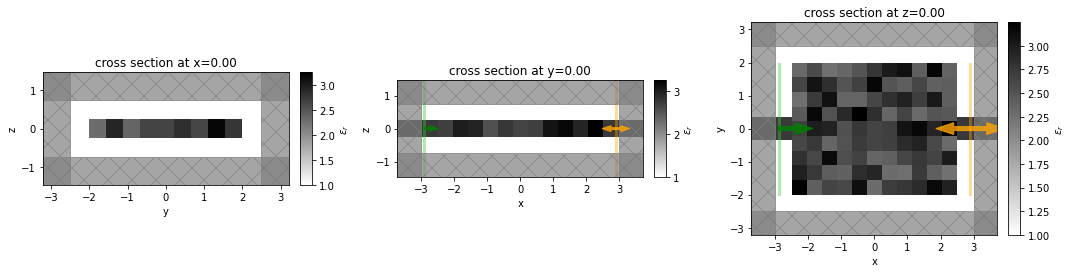

In [6]:
sim_start = make_sim(*eps_boxes)

f, axes = plt.subplots(1, 3, tight_layout=True, figsize=(15, 10))

for dim, ax in zip('xyz', axes):
    sim_start.plot_eps(**{dim:0}, ax=ax)

plt.show()

### Mode Solver

Next, let's visualize the mode profiles so we can inspect which mode indices we want to inject and transmit.

We will be converting the `mode_index=1` mode to the `mode_index=3` mode (2nd row to 4th row).

Effective index of computed modes:  [[1.3767189 1.344184  1.066289  1.059631 ]]


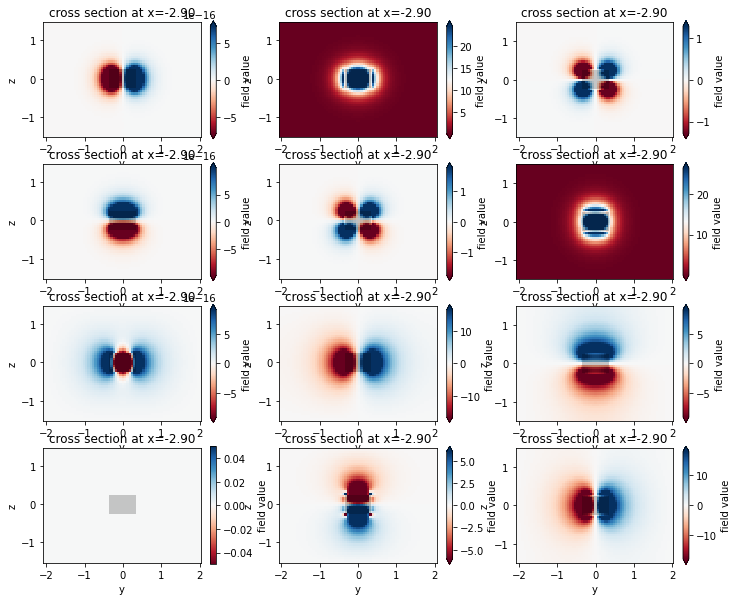

In [7]:
mode_solver = ModeSolver(simulation=sim_start, plane=forward_source, mode_spec=mode_spec, freqs=[freq0])
modes = mode_solver.solve()

print("Effective index of computed modes: ", np.array(modes.n_eff))

fig, axs = plt.subplots(num_modes, 3, figsize=(12, 10))
for mode_ind in range(num_modes):
    mode_solver.plot_field("Ex", "real", f=freq0, mode_index=mode_ind, ax=axs[mode_ind, 0])
    mode_solver.plot_field("Ey", "real", f=freq0, mode_index=mode_ind, ax=axs[mode_ind, 1])
    mode_solver.plot_field("Ez", "real", f=freq0, mode_index=mode_ind, ax=axs[mode_ind, 2])

### Post Process

We will define one more function to tell us how we want to postprocess a SimulationData object to give the conversion power that we are interest in maximizing.

In [8]:
def measure_power(sim_data: JaxSimulationData) -> float:
    """Return the power in the output_data amplitude at the mode index of interest."""
    output_amps = sim_data.output_data[0].amps
    amp = output_amps.sel(direction="+", f=freq0, mode_index=mode_index_out)
    return jnp.sum(jnp.abs(amp)**2)

### Define Objective Function

Finally, we need to define the objective function that we want to maximize as a function of our input parameters (permittivity of each box) that returns the conversion power.

In [9]:
def J(*eps_boxes, step_num:int=None) -> float:
    sim = make_sim(*eps_boxes)
    task_name = "inv_des"
    if step_num:
        task_name += f"_step_{step_num}"
    sim_data = run(sim, task_name=task_name)
    power = measure_power(sim_data)
    return power

## Inverse Design

Now we are ready to perform the optimization.

We use the `jax.value_and_grad` function to get the gradient of `J` with respect to the permittivity of each `Box`, while also returning the power associated with the current iteration, so we can record this value.

Let's try running this function once to make sure it works.

In [10]:
dJ_fn = value_and_grad(J, argnums=tuple(range(num_cells)))

### Optimization

We will use "Adam" optimization strategy to perform sequential updates of each of the `Box` permittivity values.

For more information on what we use to implement this method, see [this article](https://optimization.cbe.cornell.edu/index.php?title=Adam).

We will run 10 steps and measure both the permittivities and powers at each iteration.

We capture this process in an `optimize` function, which accepts various parameters that we can tweak.

In [11]:
permittivities = np.array(eps_boxes)

Js = []
perms = [permittivities]

def optimize(
    permittivities,
    step_size=0.2,
    num_steps=10,
    eps_max=5,
    beta1=0.9,
    beta2=0.999,
    epsilon=1e-8,
):

    mt = np.zeros_like(permittivities)
    vt = np.zeros_like(permittivities)

    for i in range(num_steps):

        t = i + 1
        print(f'step = {t}')

        eps_boxes_list = permittivities.tolist()
        power, gradient = dJ_fn(*eps_boxes_list, step_num=t)
        gradient = np.array(gradient).copy()

        mt = beta1 * mt + (1-beta1) * gradient
        vt = beta2 * vt + (1-beta2) * gradient**2

        mt_hat = mt / (1 - beta1**t)
        vt_hat = vt / (1 - beta2**t)

        update = step_size * (mt_hat / np.sqrt(vt_hat) + epsilon)

        Js.append(power)
        print(f'\tJ = {power:.4e}')
        print(f'\tgrad_norm = {np.linalg.norm(gradient):.4e}')

        permittivities += update
        permittivities[permittivities > eps_max] = eps_max
        permittivities[permittivities < 1.0] = 1.0
        perms.append(permittivities)
    return permittivities

Let's run the optimize function, note that this will take about 1 hour to complete.

In [12]:
perms_after = optimize(permittivities)
power = J(*perms_after)
Js.append(power)

↓ monitor_data.hdf5 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0% • 13.5/13.5 MB • 3.6 MB/s • 0:00:00

OSError: [Errno group not found: Ex] 'Ex'

### Results

First, we plot the objective function (power converted to 1st order mode) as a function of step and notice that it converges nicely!

The final device converts 85% of the input power to the 1st mode, up from < 1% when we started.

In [ ]:
plt.plot(Js)
plt.xlabel('iterations')
plt.ylabel('objective function')
plt.yscale('log')
plt.show()

In [ ]:
print(f'Initial power conversion = {Js[0]*100:.2f} %')
print(f'Final power conversion = {Js[-1]*100:.2f} %')

We then will visualize the final structure, so we convert it to a regular `Simulation` using the final permittivity values and plot it.

In [ ]:
sim = make_sim(*perms_after.tolist())

In [ ]:
sim_final = sim.to_simulation()[0]
sim_final.plot_eps(z=0)

Finally, we want to inspect the fields, so we add a field monitor to the `Simulation` and perform one more run to record the field values for plotting.

In [ ]:
field_mnt = td.FieldMonitor(
    size=(td.inf, td.inf, 0),
    freqs=[freq0],
    name='field_mnt',
)

sim_final = sim_final.copy(update=dict(monitors=(field_mnt,)))

In [ ]:
sim_data_final = web.run(sim_final, task_name='inv_des_final')

We notice that the behavior is as expected and the device performs exactly how we intended!

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
ax1 = sim_data_final.plot_field('field_mnt', 'Ez', z=0, ax=ax1)
ax1 = sim_data_final.plot_field('field_mnt', 'int', z=0, ax=ax2)